In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.special import rel_entr

### Load Data

In [26]:
loaded = np.load('./data/stag_hunt_O_5M.npz')
name = 'Stag Hunt Obstacle'
rewards = loaded['rewards']
checkpoints = loaded['checkpoints']
row_rewards = rewards[:,:,0]
col_rewards = rewards[:,:,1]
row_rewards

array([[17.55249433, 18.03039683, 19.39390372, 12.05007215, 21.34340514,
        16.04800755, 13.68964077,  8.7994228 , 15.84184704, 14.01742424,
        23.08535354, 27.66071429, 19.61146607, 12.86054131, 19.80897436,
         6.28045019, 16.66545455, 15.82522974,  8.17972085, 17.03133903,
        18.14285714, 11.22421466, 16.26619048, 18.47099567, 18.29528478,
        22.4362963 , 17.31953602, 15.72364469, 16.77698413, 20.12407423,
        12.97024658, 23.9654379 , 17.91679894, 26.47700855, 18.99389499,
        20.76975933, 15.71489621, 17.43905346, 15.08121265, 19.1331282 ,
        15.43412698, 21.8128462 , 17.16666667, 18.1811655 , 16.62923351,
        16.47863248, 13.58032271, 20.25641026, 23.2994154 , 17.7035723 ],
       [19.26551227, 19.70490741, 19.96972159, 21.53369535, 17.15021528,
        17.72243867, 19.2572235 , 13.49455338, 26.95468109, 26.30989595,
        21.2080267 , 19.08276919, 13.96682707, 18.5290534 , 25.53825439,
        17.97810532, 22.74927977, 19.56519962, 26.

### KL Divergence

In [27]:
# start = np.min(row_rewards)
# end = np.max(row_rewards)
start = 0
end = 150
num_bins = 50
# marginal distribution
total_rewards = row_rewards.flatten()
marginal_hist, marginal_bin_edges = np.histogram(total_rewards, bins=num_bins, range=(start, end))
marginal_distribution = marginal_hist / sum(marginal_hist)
# KL divergence
KL_divergence = np.zeros(len(row_rewards))
for i in range(len(row_rewards)):
    hist, bin_edges = np.histogram(row_rewards[i], bins=num_bins, range=(start, end))
    distribution = hist / sum(hist)
    KL_divergence[i] = sum(rel_entr(distribution,marginal_distribution))
# index
index = sum(KL_divergence)/len(KL_divergence)
print(index)

0.6174117431092346


### Turn to DataFrame

In [28]:
# convert to dataframe for plotting
checkpoint_str = ["checkpoint "+str(x) for x in checkpoints]
# reshape the 2D Numpy array to 1D array
flattened_ego_rewards = row_rewards.flatten()
flattened_opp_rewards = col_rewards.flatten()
# Create column names for the DataFrame
column_names = ['row reward', 'col reward', 'checkpoint']
# Create an array with repeated row numbers
checkpoint_names = np.repeat(checkpoint_str, len(row_rewards[0]))
# Create the DataFrame
df = pd.DataFrame({'row reward': flattened_ego_rewards, 'col reward': flattened_opp_rewards, 'checkpoint': checkpoint_names}, columns=column_names)
df

,row reward,col reward,checkpoint
0,17.552494,17.097732,checkpoint 20
1,18.030397,19.214118,checkpoint 20
2,19.393904,20.895674,checkpoint 20
3,12.050072,13.716306,checkpoint 20
4,21.343405,20.600837,checkpoint 20
...,...,...,...
545,37.059217,36.627410,checkpoint 2460
546,33.097792,35.343492,checkpoint 2460
547,37.868872,38.625017,checkpoint 2460
548,40.971091,39.019407,checkpoint 2460


### Ridge Plot

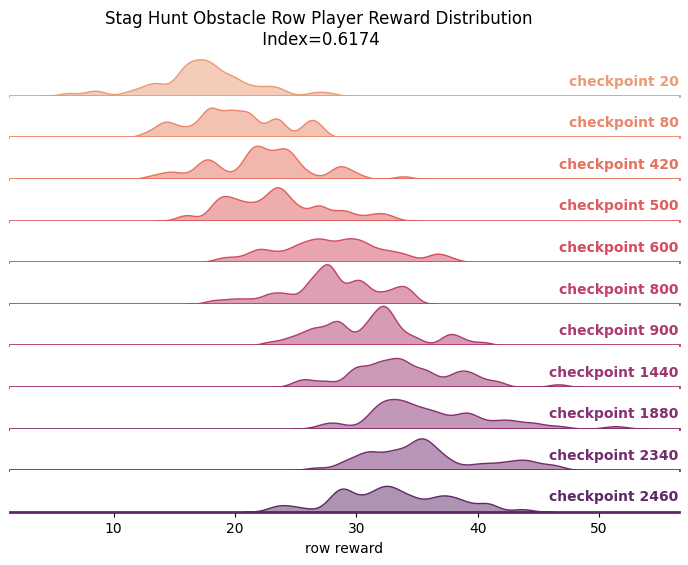

In [29]:
g = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='flare')
# h = sns.FacetGrid(df, row="checkpoint", hue="checkpoint", aspect=15, height=.5, palette='crest')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="row reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map_dataframe(sns.kdeplot, x="opp_reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(1, .2, label, fontweight="bold", color=color,
            ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "row reward")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=f'{name} Row Player Reward Distribution\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join('./plots/', name+' row reward distribution.pdf'), bbox_inches='tight')

### Comparison DataFrame

In [30]:
new_df = pd.DataFrame({'reward': df['col reward'].tolist()+df['row reward'].tolist(),
                       'label': ['col']*len(df['col reward'])+['row']*len(df['row reward']),
                       'checkpoint': df['checkpoint'].tolist()*2},
                      columns=['reward','label','checkpoint'])
new_df

,reward,label,checkpoint
0,17.097732,col,checkpoint 20
1,19.214118,col,checkpoint 20
2,20.895674,col,checkpoint 20
3,13.716306,col,checkpoint 20
4,20.600837,col,checkpoint 20
...,...,...,...
1095,37.059217,row,checkpoint 2460
1096,33.097792,row,checkpoint 2460
1097,37.868872,row,checkpoint 2460
1098,40.971091,row,checkpoint 2460


### Comparison Ridge Plot

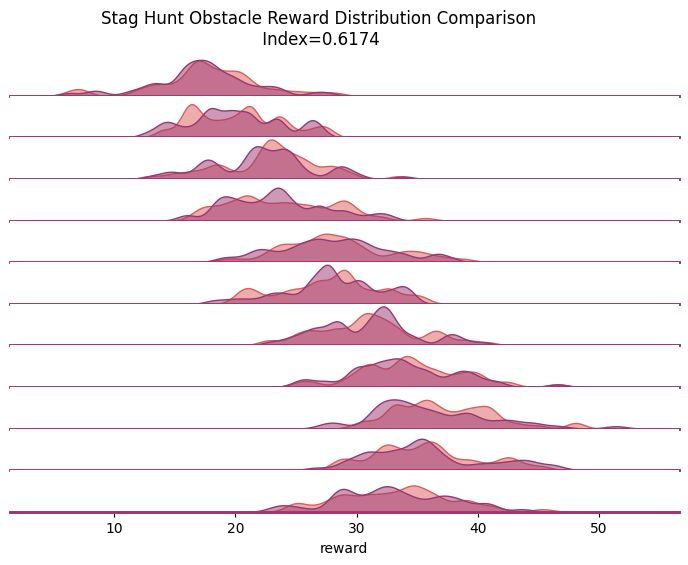

In [31]:
g = sns.FacetGrid(new_df, row="checkpoint", hue="label", aspect=15, height=.5, palette='flare')

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x="reward", bw_adjust=.4, clip_on=False, fill=True, alpha=.5, linewidth=1)
# g.map(sns.kdeplot, "reward", clip_on=False, color="w", lw=2, bw_adjust=.3)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # ax.text(1, .2, label, fontweight="bold", color=color,
    #         ha="right", va="bottom", transform=ax.transAxes)
# def annotate(data, color, **kws):
#     n = data['checkpoint']
#     ax = plt.gca()
#     ax.text(1, 0.2, f'{n}', fontweight="bold", color=color, ha="right", va="bottom", transform=ax.transAxes)

g.map(label, "reward")
# g.map_dataframe(annotate)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
title=f'{name} Reward Distribution Comparison\n Index={index:.4f}'
g.fig.suptitle(title, y=1.02)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# save figure
plt.savefig(os.path.join('./plots/', name+' distribution comparison.pdf'), bbox_inches='tight')